# Importing modules 

In [1]:
import librosa
import librosa.display
import numpy as np
import scipy
import tensorflow as tf
from sklearn import preprocessing
import keras
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.core import Lambda
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.layers import LayerNormalization
from keras.engine.topology import Layer
from keras.optimizers import SGD, Adam, Adagrad
import keras.backend as K
from keras import layers
from keras import activations
import math
import os
from datetime import datetime
import IPython.display as ipd
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt

### Some constants

In [2]:
FILE_NAME_48_AUDIO_BOOK = "01_TheSecretSharer-text (online-audio-converter.com).wav"
CURR_DIR = '.'
pi=math.pi
WAV_EXT = '.wav'
SAVE_DIR = 'saved_models'

In [3]:
datasets_dir_file = {'48 min audio-book':FILE_NAME_48_AUDIO_BOOK, 'LJ speech dataset': CURR_DIR}

# Defining all functions and classes

## Loss functions

In [4]:
def wave_loss(y_true, y_pred):
    wave_loss = 1000*1/2 * K.mean(K.abs(y_true-y_pred))
    return wave_loss 

In [5]:
def phase_loss(y_true, y_pred):
    return K.mean(K.square(tf.math.subtract(y_true, y_pred)))

## Dataset Class

In [6]:
class Dataset:
    def __init__(self, kind):
        self.kind = kind
        if self.kind not in datasets_dir_file.keys():
            raise NameError('this dataset has not been implemented yet')
            
        
    def preprocess_and_split_data(self, 
                                  sr=16000, 
                                  n_fft=8192, 
                                  hop_length=int(8192/4), 
                                  win_length=8192, 
                                  window=np.ones(8192), 
                                  normalize_input = True, 
                                  normalize_output = False,
                                  test_ratio = 0.20,
                                  val_ratio = 0.10
                                 ):
        
        if self.kind =='48 min audio-book':
            file_path = datasets_dir_file[self.kind]
            samples = self.load_audio(file_path, sr=sr)
            D = self.take_ifft(samples, n_fft = n_fft, hop_length = hop_length, win_length=win_length, window=window)
            
            ab = np.abs(D)
            ph = np.angle(D)
            ab = ab[:-1, :]
            
            y_wave = self.get_frames_wave(samples, n_fft=n_fft, stride = hop_length, n_frames = ab.shape[1])
            
            if normalize_input:
                y_real_imag = np.concatenate((self.normalize_root_square_sum(D.real[:-1, :]), self.normalize_root_square_sum(D.imag[:-1, :])))
           
            else:
                 y_real_imag = np.concatenate((D.real[:-1, :],D.imag[:-1, :]))
            
            if normalize_input:
                ab = self.normalize_root_square_sum(ab)
                #y_real_imag =  self.normalize_root_square_sum(y_real_imag)
            
            if normalize_output:
                y_wave = self.normalize_root_square_sum(y_wave)
                
            X_train, X_test = self.split_test_train_raw(arr=ab, test_ratio = test_ratio)
            X_train, X_val = self.split_test_train_raw(arr=X_train, test_ratio = val_ratio)
            
            y_phase_train, y_phase_test = self.split_test_train_raw(arr = y_real_imag, test_ratio = test_ratio)
            y_phase_train, y_phase_val = self.split_test_train_raw(arr = y_phase_train, test_ratio = val_ratio)
            
            
            y_wave_train, y_wave_test = self.split_test_train_raw(arr = y_wave, test_ratio = test_ratio)
            y_wave_train, y_wave_val = self.split_test_train_raw(arr = y_wave_train, test_ratio = val_ratio)
            
            return X_train.T, X_val.T, X_test.T, y_phase_train.T, y_phase_val.T, y_phase_test.T, y_wave_train.T, y_wave_val.T, y_wave_test.T
            
        elif self.kind =='LJ speech dataset':
            ab_before_7000 = np.load('ab_512.npy')
            ab_after_7000 = np.load('ab_7000_512.npy')
            ab = np.concatenate((ab_before_7000, ab_after_7000))
            ab =  ab[:, :-1]
            
            y_real_imag_before_7000 = np.load('y_real_imag_512.npy')
            y_real_imag_after_7000 = np.load('y_real_imag_7000_512.npy')
            y_real_imag = np.concatenate((y_real_imag_before_7000, y_real_imag_after_7000))
            
            y_wave_before_7000 = np.load('y_wave_512.npy')
            y_wave_after_7000 = np.load('y_wave_7000_512.npy')
            y_wave = np.concatenate((y_wave_before_7000, y_wave_after_7000))
            
            X_train, X_test = self.split_test_train_raw(arr=ab.T, test_ratio = test_ratio)
            X_train, X_val = self.split_test_train_raw(arr=X_train, test_ratio = val_ratio)
            
            y_phase_train, y_phase_test = self.split_test_train_raw(arr = y_real_imag.T, test_ratio = test_ratio)
            y_phase_train, y_phase_val = self.split_test_train_raw(arr = y_phase_train, test_ratio = val_ratio)
            
            
            y_wave_train, y_wave_test = self.split_test_train_raw(arr = y_wave.T, test_ratio = test_ratio)
            y_wave_train, y_wave_val = self.split_test_train_raw(arr = y_wave_train, test_ratio = val_ratio)

            return X_train.T, X_val.T, X_test.T, y_phase_train.T, y_phase_val.T, y_phase_test.T, y_wave_train.T, y_wave_val.T, y_wave_test.T
            
        
        
    def save_to_npy(self, arr, file_name):
        np.save(arr, file_name)
    
    
    def split_test_train_built_in(self):
        # to be done
        pass
        
    def split_test_train_raw(self, arr, test_ratio):
        train_slice = int(arr.shape[1]*(1-test_ratio))
        return arr[:, 0:train_slice], arr[:, train_slice:]
    
        
    
    def get_frames_wave(self, samples, n_fft, stride, n_frames):
        s = samples[0:n_fft]
        lst=[s]
        for i in range(n_frames-1):
            first = (i+1)*stride
            last = ((i+1)*stride)+n_fft
            app = samples[first : last]
            lst.append(app)
        s = np.array(lst)
        s = np.transpose(s)
        return s
            
           
    def load_audio(self, file_path, sr=16000):
        samples, _ = librosa.load(file_path, sr= sr, mono = True, offset = 0.0, duration = None)
        return samples
    
    
    def take_ifft(self, samples, n_fft, hop_length, win_length, window):
        D = librosa.stft(samples, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=False)
        return D
    
    
    def normalize_root_square_sum(self, arr):
        #square each element
        ab_sq = np.square(arr)
        #sum of ab_sq along frequencies
        ab_sq_sum = np.sum(ab_sq, axis = 0)
        #square root
        sqrt_ab = np.sqrt(ab_sq_sum)
        #normalize
        norm_ab = np.divide(arr,sqrt_ab)
        #replace nan to zero
        norm_ab = np.nan_to_num(norm_ab)
        return norm_ab
    
    def normalize_min_max(self, arr):
        # to be done
        pass
    
        
        

## Get real and imaginary multipliers for ifft layer 

In [7]:
def get_real_imag_multipliers(N, real):
    def f_cos(a, N):
        return 2/N*np.cos(2*pi*a/N)

    def f_sin(a, N):
        return -2/N*np.sin(2*pi*a/N)

    n_k_mult = [[r*c for c in range(real)] for r in range(N)]
    vfunc =np.vectorize(f_cos)
    n_k_mult_cos = vfunc(n_k_mult, N)
    n_k_mult_cos = np.transpose(n_k_mult_cos)
    n_k_mult_cos = tf.convert_to_tensor(n_k_mult_cos, dtype='float32')
    vfunc =np.vectorize(f_sin)
    n_k_mult_sin = vfunc(n_k_mult, N)
    n_k_mult_sin = np.transpose(n_k_mult_sin)
    n_k_mult_sin = tf.convert_to_tensor(n_k_mult_sin, dtype='float32')
    return n_k_mult_cos, n_k_mult_sin

## Model class

In [8]:
class Multi_Loss_Model:
    @staticmethod
    def _call_dense_layer(inputs, dim_hidden, activation = LeakyReLU(alpha=0.3) , name=None, dropout = None, bias = None, layer_norm=False):
        
        if bias:
            out = Dense(dim_hidden, activation=activation, name=name, use_bias=True, bias_initializer="ones")(inputs)
            
        else:
            out = Dense(dim_hidden, activation=activation, name=name)(inputs)
        
        if layer_norm:
            #out = BatchNormalization()(out)
            out = LayerNormalization()(out)
        
        if dropout:
            out = tf.keras.layers.Dropout(dropout)(out)
        
        return out

    
    @staticmethod
    def ifft_layer(x):
        global n_k_mult_cos
        global n_k_mult_sin 
        global real
        final = tf.matmul(x[:, :real], n_k_mult_cos) + tf.matmul(x[:, real:], n_k_mult_sin)
        return final
    
    @staticmethod
    def _build(inputs_shape, dim_hidden, activations, dropout = None, bias=None):
        inputs = Input(shape=inputs_shape)
        
        for i, dim in enumerate(dim_hidden):
            name = "out_for_phase" if i == n_hidden - 1 else None
            dropout = None if i == n_hidden - 1 else dropout
            activation = None if i+1>len(activations) else activations[i]
            
            if i==n_hidden-1 and i==0:
                out = Multi_Loss_Model._call_dense_layer(inputs = inputs, dim_hidden = dim, name = name, dropout=dropout, bias=bias, layer_norm=False, activation = activation)
            elif i==n_hidden-1:
                out = Multi_Loss_Model._call_dense_layer(inputs = out, dim_hidden = dim, name = name, dropout=dropout, bias=bias, layer_norm=False, activation = activation)
            elif i == 0:
                out = Multi_Loss_Model._call_dense_layer(inputs = inputs, dim_hidden = dim, name = name, dropout=dropout, bias=bias, activation = activation)   
            else:
                out = Multi_Loss_Model._call_dense_layer(inputs = out, dim_hidden = dim, name = name, dropout=dropout, bias=bias, activation = activation)    
        
        
        out_for_phase = out
        out_for_wave = Lambda(Multi_Loss_Model.ifft_layer, name = "out_for_wave")(out)
        
        model = Model(
            inputs=inputs,
            outputs=[out_for_phase, out_for_wave],
            name="model_final")
        
        # return the constructed network architecture
        return model

    
        
                

## Model Utils

In [9]:
def build_and_compile(inputs_shape,
                     dim_hidden, 
                     activations, 
                     dropout,
                     bias,
                     opt, 
                     losses, 
                     lossWeights):
    model = Multi_Loss_Model._build(inputs_shape = X_train.shape[1], dim_hidden = dim_hidden, activations=activations, dropout = dropout, bias = bias)
    model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights)
    return model

In [10]:
def get_model_summary(model):
    return model.summary()

In [11]:
def train_model(model, X_train, X_val, X_test, 
           y_phase_train, y_phase_val, y_phase_test,
           y_wave_train, y_wave_val, y_wave_test, 
           epochs, 
           batch_size = None,
            use_one_frame = False,
            callbacks = []):
    
    if use_one_frame:
        global frame_number
        history = model.fit(x=X_train[frame_number-1:frame_number, :],
                            y={"out_for_phase": y_phase_train[frame_number-1:frame_number, :], "out_for_wave": y_wave_train[frame_number-1:frame_number, :]},
                            validation_data=(X_val[frame_number-1:frame_number, :],
                                {"out_for_phase": y_phase_val[frame_number-1:frame_number, :], "out_for_wave": y_wave_val[frame_number-1:frame_number, :]}),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=callbacks,
                            shuffle = True,
                            verbose=1)
    else:
        history = model.fit(x=X_train,
                            y={"out_for_phase": y_phase_train, "out_for_wave": y_wave_train},
                            validation_data=(X_val,
                                {"out_for_phase": y_phase_val, "out_for_wave": y_wave_val}),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks = callbacks,
                            shuffle = True,
                            verbose=1)
    
    
    return history
           

In [12]:
def plot_history(history, epochs):
    if len(history.history['loss']) < epochs:
        epochs = len(history.history['loss'])
    lossNames = ["loss", "out_for_phase_loss", "out_for_wave_loss"]
    plt.style.use("ggplot")
    (fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

    for (i, l) in enumerate(lossNames):
        # plot the loss for both the training and validation data
        title = "Loss for {}".format(l) if l != "loss" else "Total loss"
        ax[i].set_title(title)
        ax[i].set_xlabel("Epoch #")
        ax[i].set_ylabel("Loss")
        ax[i].plot(np.arange(0, epochs), history.history[l], label=l)
        ax[i].plot(np.arange(0, epochs), history.history["val_" + l],
            label="val_" + l)
        ax[i].legend()

In [13]:
def save_model(model, comments=""):
    global SAVE_DIR
    date = datetime.now().strftime("%Y_%m_%d-%I:%M:%S_%p")
    file_name = f"{comments}_{date}.h5"
    file_name = os.path.join(SAVE_DIR, file_name)
    model.save(file_name)
    print(f"Model saved with file name: {file_name}")

In [14]:
def predict(model, 
           X):
    return model.predict(X)

In [15]:
def plot_wave_one_frame(prediction, y_true, frame_number=1000, left_index=1000, right_index=2000,):
    prediction = np.array(prediction, 'float32')
    
    plt.figure(figsize=(14, 5))

#     if use_one_frame:
#         librosa.display.waveplot(prediction[1, frame_number-1:frame_number, :].reshape(-1)[:zoom_end_index], sr=sr, color = 'b', alpha = 0.5, label= 'predicted')
#     else:
#         librosa.display.waveplot(np.concatenate(prediction[:, 1, :])[:zoom_end_index], sr=sr, color = 'b', alpha = 0.5, label= 'predicted')
    
#     if use_one_frame:
#         librosa.display.waveplot(np.concatenate(y_true[frame_number-1:frame_number, :])[:zoom_end_index], sr=sr, color = 'r', alpha=0.30, label = 'true')
#     else:
#         librosa.display.waveplot(np.concatenate(y_true[n_s-1:n_s, :])[:zoom_end_index], sr=sr, color = 'r', alpha=0.25, label='true')
    
    
    librosa.display.waveplot(prediction[1, frame_number-1:frame_number, :].reshape(-1)[left_index:right_index], sr=sr, color = 'b', alpha = 0.5, label= 'predicted')
    librosa.display.waveplot(np.concatenate(y_true[frame_number-1:frame_number, :])[left_index:right_index], sr=sr, color = 'r', alpha=0.30, label = 'true')
    
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()
    
    

In [16]:
def plot_wave_all_frames(prediction, y_true, zoom_end_index=-1):
    # to implement 
    pass

In [17]:
def listen_to_audio(audio, sr):
    ipd.Audio(audio, rate=sr)

In [18]:
def reconstruct_audio_with_overlapping(signal):
    pass

# Prepating training data (can be run once)

### Data parameters

In [19]:
kind_of_dataset = '48 min audio-book'
#kind_of_dataset = 'LJ speech dataset'

sr=16000 
n_fft=512
#n_fft=8192
#n_fft=1024
real = int(n_fft/2)
hop_length=int(n_fft/4)
win_length=n_fft
window=np.ones(n_fft) 
normalize_input = False 
normalize_output = False
test_ratio = 0.20
val_ratio = 0.10


### Getting data

In [20]:
dataset = Dataset(kind = kind_of_dataset)
X_train, X_val, X_test, y_phase_train, y_phase_val, y_phase_test, y_wave_train, y_wave_val, y_wave_test = dataset.preprocess_and_split_data(
                                                                                                        sr=sr, 
                                                                                                        n_fft=n_fft, 
                                                                                                        hop_length = hop_length,
                                                                                                        win_length=win_length,
                                                                                                        window = window, 
                                                                                                        normalize_input = normalize_input, 
                                                                                                        normalize_output = normalize_output, 
                                                                                                        test_ratio = test_ratio, 
                                                                                                        val_ratio = val_ratio
                                                                                                        )

In [21]:
print(f"X train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"y_phase_train: {y_phase_train.shape}, y_phase_val: {y_phase_val.shape}, y_phase_test: {y_phase_test.shape}")
print(f"y_wave_train: {y_wave_train.shape}, y_wave_val: {y_wave_val.shape}, y_wave_test: {y_wave_test.shape}")

X train: (260222, 256), X_val: (28914, 256), X_test: (72284, 256)
y_phase_train: (260222, 512), y_phase_val: (28914, 512), y_phase_test: (72284, 512)
y_wave_train: (260222, 512), y_wave_val: (28914, 512), y_wave_test: (72284, 512)


### Real and Imaginary multipliers

In [22]:
n_k_mult_cos, n_k_mult_sin = get_real_imag_multipliers(N=n_fft, real = real)

# Training the model

### Set hyperparameters

In [33]:
# hyperparameters
EPOCHS= 100
ALPHA = 0

LR = 0.001
#opt = Adam(lr=LR)
opt = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.0, nesterov=False, name="SGD")
dropout = 0.2
bias = True

losses = {
    "out_for_wave": wave_loss,
    "out_for_phase": phase_loss
    }


#activation_function = 'tanh'
#activation_function = LeakyReLU(alpha=0.3)
activation_function = None

n_hidden = 3

batch_size = 256
use_one_frame = False
use_early_stopping = False
patience_early_stopping = 100


frame_number = 1000 if use_one_frame else None
activations = [activation_function]*(n_hidden-1)
#activations = [activation_function]*(n_hidden)
lossWeights = {"out_for_phase": ALPHA, "out_for_wave": 1-ALPHA}
#dim_hidden = [n_fft]*n_hidden
dim_hidden = [512, 512, n_fft]

if use_one_frame:
    use_early_stopping=False
    
comments = f"alpha_{ALPHA}_epochs_{EPOCHS}_n_fft_{n_fft}_activation_{activation_function}_n_hidden_{n_hidden}"

### Compile the model

In [34]:
try:
    model
except:
    pass
else:
    del model


model = build_and_compile(inputs_shape = X_train.shape[1],
                  dim_hidden = dim_hidden, 
                  activations=activations, 
                  dropout = dropout, 
                  bias = bias,
                 opt = opt, 
                 losses = losses,
                 lossWeights = lossWeights)

print(get_model_summary(model))


Model: "model_final"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
out_for_phase (Dense)        (None, 512)               262656    
_________________________________________________________________
out_for_wave (Lambda)        (None, 512)               


### Early stopping

In [35]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=patience_early_stopping,
                              verbose=1, mode='auto')

### Train the model (input comments for saving)

In [36]:
history = train_model(model,
                X_train, X_val, X_test, 
                y_phase_train, y_phase_val, y_phase_test, 
                y_wave_train, y_wave_val, y_wave_test,
                epochs= EPOCHS, 
                batch_size = batch_size,
                use_one_frame = use_one_frame, 
                callbacks = [early_stopping_callback] if use_early_stopping else [])

save_model(model, comments=comments)

Epoch 1/100
1017/1017 [==============================] - 6s 5ms/step - loss: 38.4576 - out_for_phase_loss: 3.6987 - out_for_wave_loss: 38.4576 - val_loss: 23.3734 - val_out_for_phase_loss: 1.7789 - val_out_for_wave_loss: 23.3734
Epoch 2/100
1017/1017 [==============================] - 5s 5ms/step - loss: 30.1695 - out_for_phase_loss: 2.2538 - out_for_wave_loss: 30.1695 - val_loss: 22.6497 - val_out_for_phase_loss: 1.7005 - val_out_for_wave_loss: 22.6497
Epoch 3/100
1017/1017 [==============================] - 5s 5ms/step - loss: 28.7568 - out_for_phase_loss: 2.0973 - out_for_wave_loss: 28.7568 - val_loss: 22.4125 - val_out_for_phase_loss: 1.6843 - val_out_for_wave_loss: 22.4125
Epoch 4/100
1017/1017 [==============================] - 5s 5ms/step - loss: 27.9621 - out_for_phase_loss: 2.0240 - out_for_wave_loss: 27.9621 - val_loss: 22.3007 - val_out_for_phase_loss: 1.6769 - val_out_for_wave_loss: 22.3007
Epoch 5/100
1017/1017 [==============================] - 5s 5ms/step - loss: 27.4186

In [37]:
len(history.history['loss'])

100

### Plot learning curves

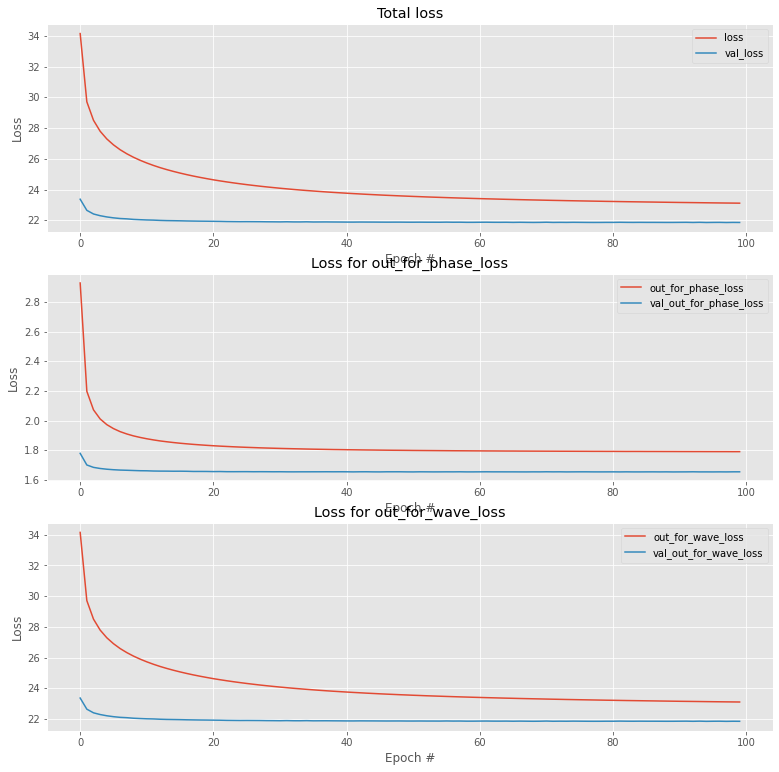

In [38]:
plot_history(history=history,
             epochs = EPOCHS)        

### Make predictions for train

In [58]:
if use_one_frame:
    train_predictions = predict(model, X=X_train[frame_number-1:frame_number, :])
else:
    train_predictions = predict(model, X=X_train[:50000, :])
train_predictions[1].shape


print(y_wave_train.shape)

None
(260222, 512)


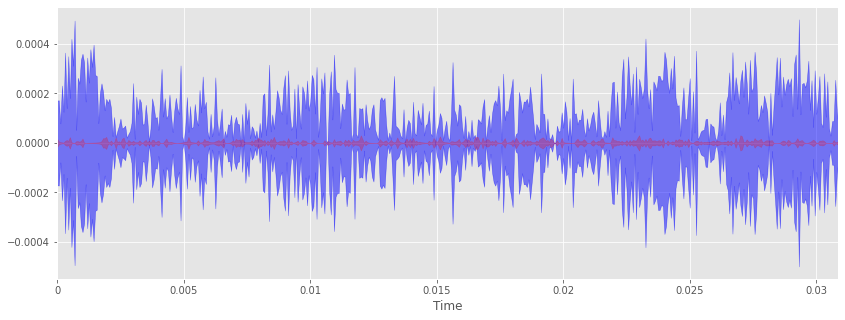

In [62]:
plt.figure(figsize=(14, 5))
#ipd.Audio(np.concatenate(train_predictions[1][1000:1050, :], rate=sr))
#ipd.Audio(y_wave_train[1000-1:1000, :], rate=sr)
librosa.display.waveplot(np.concatenate(train_predictions[1])[5:500], sr=sr, color = 'b', alpha = 0.5)
librosa.display.waveplot(np.concatenate(y_wave_train[999:1000, :])[5:500], sr=sr, color = 'r', alpha=0.25)
#ipd.Audio(train_predictions[1], rate=sr)


### Plot wave and display audio for train

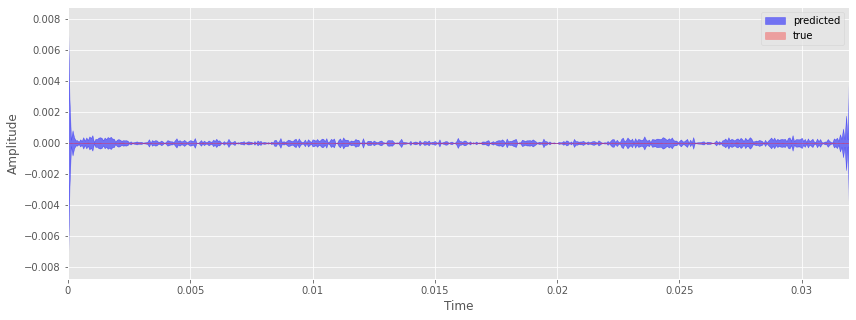

In [44]:
left_index, right_index = 0, 1000

plot_wave_one_frame(train_predictions, y_wave_train, frame_number=frame_number if frame_number else 1000, left_index = left_index, right_index=right_index)


### Listen to train data

In [ ]:
# to do
#listen_to_audio()

### Make predictions for test

In [45]:
test_predictions = predict(model, X=X_test)
test_predictions[1].shape

(72284, 512)

### Plot wave and display audio for test

In [46]:
frame_number_test = np.random.randint(low = 1, high = test_predictions[1].shape[0]-1, size=1)[0]
left_index, right_index = 800, 1200

plot_wave_one_frame(test_predictions, y_wave_test, frame_number = frame_number_test, left_index = left_index, right_index=right_index)


ParameterError: Input is too short (n=0) for frame_length=1

<Figure size 1008x360 with 0 Axes>